# Seqlet Extraction using the Nanog GkmExplain Scores

This notebook just runs the seqlet extraction portion of TF-MoDISco on the importance scores obtained from GkmExplain on Nanog ChIP-seq data in H1ESCs. See https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb for a notebook demonstrating how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

TF-MoDISco is using the TensorFlow backend.
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip -f positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip -f gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_dnshuff_hypimpscores.txt.gz -O gkmexplain_dnshuff_hypimpscores.txt.gz
!gunzip -f gkmexplain_dnshuff_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
!gunzip -f dnshuff_seqs.fa.gz

--2020-04-21 18:13:51--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: 'positives_test.fa.gz'

100%[======================================>] 75,038      --.-K/s   in 0.04s   

2020-04-21 18:13:51 (2.01 MB/s) - 'positives_test.fa.gz' saved [75038/75038]

--2020-04-21 18:13:51--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3191036 (3.0M) [application/octet-stream]
Saving to: 'gkmexplain_positives_hypimpscores.txt.gz'

100%[=

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_in_seqs_and_scores(fa_file, hypimpscores_file):
    seqs = [x.rstrip() for (i,x) in enumerate(open(fa_file)) if i%2==1]
    #filter out any sequences that contain 'N's
    onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                   for x in seqs if ('N' not in x)]
    #read in the hypothetical importance scores,
    # filter out any sequences that contain 'N's
    unnorm_hyp_impscores = [w[0] for w in zip([
        np.array( [[float(z) for z in y.split(",")]
            for y in x.rstrip().split("\t")[2].split(";")])
        for x in open(hypimpscores_file)],seqs)
        if 'N' not in w[1]]
    #in the original GkmExplain paper, a normalization of the importance scores and
    # hypothetical importance scores was proposed, as this was empirically observed to improve
    # the signal-to-noise ratio. Here, I will do a similar-in-spirit normalization that also
    # appears to improve the signal-to-noise ratio, but which is more intuitive and better-motivated
    # than the normalization from the gkmexplain paper (the reason I didn't propose it in that paper
    # is simply that I hadn't considered it).
    #The normalization consists of subtracting the mean hypothetical importance across ACGT at each
    # position such that the sum of the hypothetical importance at each position is 0. The intuition
    # is that this highlights the impact of each base on the output **relative to the other bases that
    # could have been present**. The normalized actual importance is simply the normalized hypothetical
    # importance multiplied by the one-hot encoding.
    hyp_impscores = [x - np.mean(x, axis=-1)[:,None] for x in unnorm_hyp_impscores]
    impscores = [x*y for x,y in zip(hyp_impscores, onehot_data)]
    
    return onehot_data, hyp_impscores, impscores
    

onehot_data, hyp_impscores, impscores = read_in_seqs_and_scores(
    fa_file="positives_test.fa",
    hypimpscores_file="gkmexplain_positives_hypimpscores.txt")
print("Num onehot sequences:",len(onehot_data))

_, _, nulldist_impscores = read_in_seqs_and_scores(
    fa_file="dnshuff_seqs.fa",
    hypimpscores_file="gkmexplain_dnshuff_hypimpscores.txt")
nulldist_perposimp = np.sum(nulldist_impscores, axis=-1)

Num onehot sequences: 960


NOTE: in the original GkmExplain paper, a normalization of the importance scores and hypothetical importance scores was proposed, as this was empirically observed to improve the signal-to-noise ratio. For simplicity, we are not applying that normalization here. For details on that normalization, see the Nanog TF-MoDISco notebook in the GkmExplain repo: https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb

Sanity check the scores by plotting

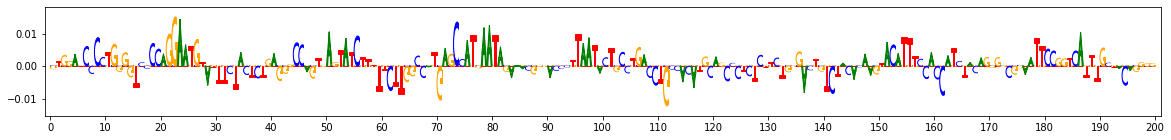

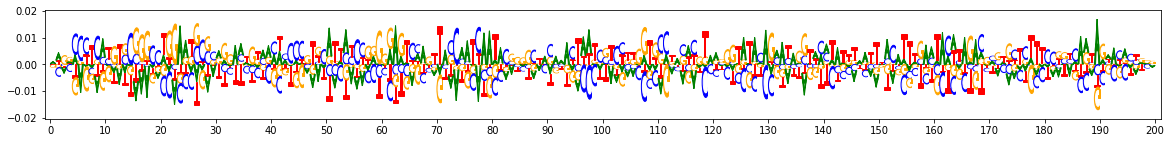

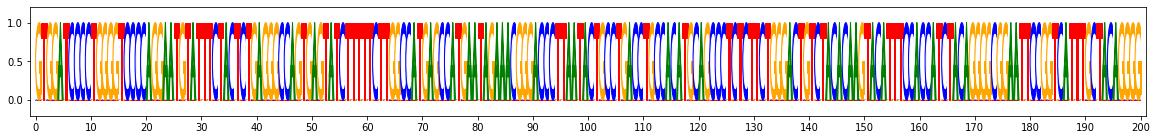

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Extract seqlets

The setting `just_return_seqlets=True` causes TF-MoDISco to terminate after the seqlet extraction step.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.

The resulting seqlets will have a size of `sliding_window_size + 2*flank_size`.

MEMORY 0.323629056
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


Thresholds from null dist were -0.21752344639999993  and  0.13906743924999995
Final raw thresholds are -0.21752344639999993  and  0.13906743924999995
Final transformed thresholds are -0.9723900462962963  and  0.8939699074074074


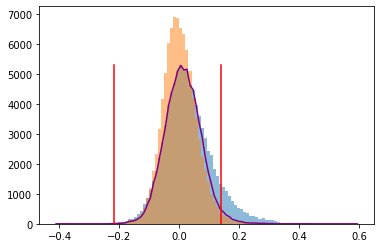

Got 1106 coords
After resolving overlaps, got 1106 seqlets
Across all tasks, the weakest transformed threshold used was: 0.8938699074074075
MEMORY 0.331501568
1106 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [1086]
Idx to activities:  {0: '1'}
MEMORY 0.331501568
On metacluster 0
Metacluster size 1086
Relevant tasks:  ('task0',)
Relevant signs:  (1,)


In [6]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                        target_seqlet_fdr=0.25,
                        sliding_window_size=21, #this is the default value
                        flank_size=10 #this is the default value
                   )(
                #There is only one task, so we just call this 'task0'
                task_names=["task0"],
                contrib_scores={'task0': impscores},                
                hypothetical_contribs={'task0': hyp_impscores},
                one_hot=onehot_data,
                null_per_pos_scores={'task0': nulldist_perposimp},
                just_return_seqlets=True)

## Print the seqlets

In this example, there is only one metacluster (metacluster '0'), so we will print the seqlets falling in that metacluster

In [7]:
output_fh = open("seqlets.fa", 'w')
seqlets = tfmodisco_results.metacluster_idx_to_submetacluster_results[0].seqlets
idx_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
for seqlet in seqlets:
    sequence = "".join([idx_to_letter[x] for x in np.argmax(seqlet["sequence"].fwd, axis=-1)])
    ex_idx = seqlet.coor.example_idx
    start = seqlet.coor.start
    end = seqlet.coor.end
    output_fh.write(">ex"+str(ex_idx)+":"+str(start)+"-"+str(end)+"\n")
    output_fh.write(sequence+"\n")
output_fh.close()

In [8]:
!head seqlets.fa

>ex3:2-43
AAGGTTTGTCTTGTTATGCAGATAAGATCTCTCTGGTGATA
>ex3:126-167
TCACAAAAGGGGAGATTTATATTCTATTGTTAGGCATTTAG
>ex5:58-99
GCGCCCCACCTCCAGCTGTTCTCCTCAGGGATGCCTCATTC
>ex11:61-102
CTTTTCTGGGCAGCAGGCAAGAACCCATCAGGTTGCTACAC
>ex13:42-83
AGTAGGAAGTACCTTTGTTCAAAAGGGACAACAGAACTCAA
